In [3]:
import ROOT as r
from ROOT.Math import XYZVector
import math
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics

Welcome to JupyROOT 6.16/00


In [4]:
dataDir = "/mnt/c/users/llave/Documents/CMS/data/"
workDir = "/mnt/c/users/llave/Documents/CMS/work/"       # somewhere to have Infos.h
eleDataDir = dataDir + "SingleEle2017F_selection_fullSel/"
amsbDataDir = dataDir + "AMSB_800GeV_10000cm_selection_fullSelV4/"
trainDir = dataDir + "train_slides/"
fiducialMapFileName = "electronFiducialMap_2017_data.root"

In [5]:
fiducialMapFile = r.TFile(dataDir+fiducialMapFileName)
beforeVeto = fiducialMapFile.Get("beforeVeto_2017F")
afterVeto = fiducialMapFile.Get("afterVeto_2017F")

In [6]:
mean_ineff = afterVeto.Integral()/beforeVeto.Integral()

nx = beforeVeto.GetNbinsX()
ny = beforeVeto.GetNbinsY()

ineffs = []
sum_ineff=0
for ix in range(nx):
    for iy in range(ny):
        before_bin = beforeVeto.GetBinContent(ix,iy)
        after_bin = afterVeto.GetBinContent(ix,iy)
        if(before_bin == 0): continue
        ineff_bin = after_bin*1.0/before_bin
        ineffs.append(ineff_bin)
        sum_ineff += pow(ineff_bin - mean_ineff,2)
stddev_mean_ineff = math.sqrt(sum_ineff/(nx*ny-1))

print("Found a mean_ineff of",round(mean_ineff,5))
print("Found a stddev_mean_ineff of",round(stddev_mean_ineff,5))

Found a mean_ineff of 0.01947
Found a stddev_mean_ineff of 0.02729


In [7]:
r.gROOT.ProcessLine('.L '+str(workDir)+'Infos.h++')

0

Info in <TUnixSystem::ACLiC>: creating shared library /mnt/c/users/llave/Documents/CMS/work/Infos_h.so


In [8]:
def calculate_effs(filesDir, sigma_cuts):
    
    overall_eff = []
    sigmas = []
    for icut, cut in enumerate(sigma_cuts):
        n_total, n_pass = 0, 0
        for file in os.listdir(filesDir):
            if not("hist" in file and ".root" in file): continue
            dataFile = r.TFile(filesDir+file)
            tree = dataFile.Get("sTree")

            for event in tree:
                for track in event.tracks:
                    n_total +=1
                    momentum = XYZVector(track.px,track.py,track.pz)
                    track_eta = momentum.Eta()
                    track_phi = momentum.Phi()
                    
                    ecalo_energy = 0
                    for hit in event.recHits:
                        detIndex = hit.detType
                        if(not(detIndex == 0 or detIndex == 1 or detIndex == 4)): continue
                        dEta = track_eta - hit.eta
                        dPhi = track_phi - hit.phi
                        if(math.sqrt(dEta*dEta+dPhi*dPhi)<0.5): ecalo_energy += hit.energy

                    thisBinX, thisBinY = -1,-1
                    for ix in range(nx):
                        found = False
                        if(afterVeto.GetXaxis().GetBinLowEdge(ix) < track_eta):
                            if(ix == nx): found = True
                            if(afterVeto.GetXaxis().GetBinLowEdge(ix+1) > track_eta): found = True
                        if(not found): continue

                        for iy in range(ny):
                            found = False
                            if(afterVeto.GetYaxis().GetBinLowEdge(iy) < track_phi):
                                if(iy == ny): found = True
                                if(afterVeto.GetYaxis().GetBinLowEdge(iy+1) > track_phi): found = True

                            if(found):
                                thisBinX = ix
                                thisBinY = iy

                    before_bin = beforeVeto.GetBinContent(thisBinX,thisBinY)
                    after_bin = afterVeto.GetBinContent(thisBinX,thisBinY)
                    if(before_bin == 0): 
                        if(icut == 0): sigmas.append(0)
                        n_pass+=1
                        continue
                    this_bin_ineff = after_bin*1.0/before_bin
                    if(icut == 0): sigmas.append((this_bin_ineff - mean_ineff)/stddev_mean_ineff)
                    if ((this_bin_ineff - mean_ineff) > cut * stddev_mean_ineff):
                        continue
                    else:
                        n_pass+=1

        overall_eff.append(n_pass*1.0/n_total)
        
    return sigmas, overall_eff

In [9]:
sigma_cuts = np.arange(0,5,0.1)
sigma_cuts = np.concatenate((sigma_cuts,np.arange(5,50,1)))

In [10]:
print("This might take a while, running over sigmas",sigma_cuts)
bkg_sigmas, bkg_effs = calculate_effs(eleDataDir, sigma_cuts)
s_sigmas, s_effs = calculate_effs(amsbDataDir, sigma_cuts)
np.save(dataDir+"SingleEle2017F_fullSel_effs.npy", bkg_effs)
np.save(dataDir+"AMSB_800GeV_10000cm_fullSel_effs.npy", s_effs)

This might take a while, running over sigmas [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49. ]


In [11]:
bkg_effs = np.load(dataDir+"SingleEle2017F_fullSel_effs.npy")
s_effs = np.load(dataDir+"AMSB_800GeV_10000cm_fullSel_effs.npy")

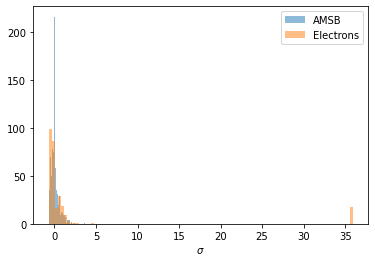

In [16]:
_ = plt.hist(s_sigmas, bins=100,label="AMSB",alpha=0.5)
_ = plt.hist(bkg_sigmas, bins=100,label="Electrons",alpha=0.5)
plt.xlabel(r"$\sigma$")
plt.legend()

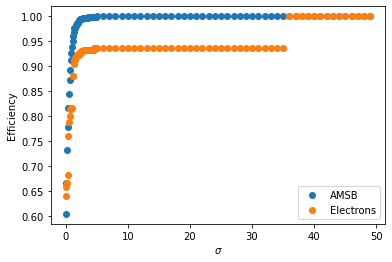

In [15]:
plt.scatter(sigma_cuts,s_effs,label="AMSB")
plt.scatter(sigma_cuts,bkg_effs,label="Electrons")
plt.ylabel("Efficiency")
plt.xlabel(r"$\sigma$")
plt.legend()

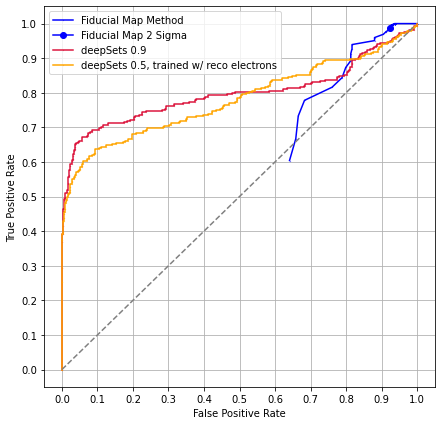

In [17]:
roc = np.load(dataDir+"roc_fullSel.npz")
tpr = roc['tpr']
fpr = roc['fpr']

roc_recoEle = np.load(dataDir+"roc_fullSel_recoEle.npz")
tpr_recoEle = roc_recoEle['tpr']
fpr_recoEle = roc_recoEle['fpr']

# roc_noEcalo = np.load(dataDir+"roc_noEcaloCut.npz")
# tpr_noEcalo = roc_noEcalo['tpr']
# fpr_noEcalo = roc_noEcalo['fpr']

# roc_0p99 = np.load(dataDir+"roc_0p99.npz")
# tpr_0p99 = roc_0p99['tpr']
# fpr_0p99 = roc_0p99['fpr']

# roc_0p7 = np.load(dataDir+"roc_0p7.npz")
# tpr_0p7 = roc_0p7['tpr']
# fpr_0p7 = roc_0p7['fpr']

# roc_mod = np.load(dataDir+"roc_mod.npz")
# tpr_mod = roc_mod['tpr']
# fpr_mod = roc_mod['fpr']

plt.figure(figsize=(7, 7))
plt.plot(bkg_effs, s_effs, '-o', markersize = 0.2, color='blue',label="Fiducial Map Method")
plt.plot(bkg_effs[np.where(sigma_cuts == 2.0)], s_effs[np.where(sigma_cuts==2.0)], '-o', color='blue', label="Fiducial Map 2 Sigma")
plt.plot(tpr, fpr, '-o', markersize=0.2, label="deepSets 0.9", color='crimson')
plt.plot(tpr_recoEle, fpr_recoEle, '-o', markersize=0.2, label="deepSets 0.5, trained w/ reco electrons", color='orange')
#plt.plot(tpr_noEcalo, fpr_noEcalo, '-o', markersize=0.2, label="deepSets 0.9, data without Ecalo cut", color='green')
# plt.plot(tpr_0p99, fpr_0p99, '-o', markersize=0.2, label="deepSets 0.99", color='orange')
# plt.plot(tpr_0p7, fpr_0p7, '-o', markersize=0.2, label="deepSets 0.7", color='gold')
# plt.plot(tpr_mod, fpr_mod, '-o', markersize=0.2, label="deepSets mod", color='green')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01), '--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
_ = plt.xticks(np.arange(0,1.1,0.1))
_ = plt.yticks(np.arange(0,1.1,0.1))

In [18]:
auc_0p9 = metrics.auc(tpr, fpr)
auc_orig = metrics.auc(bkg_effs, s_effs)
print(auc_0p9, auc_orig)

0.797681232370623 0.31755078685192745


In [19]:
outputs = np.load(dataDir+"validation_outputs.npz")
true = outputs['truth']
preds = outputs['predicted']
ecalo_energy = outputs['ecalo_energy']

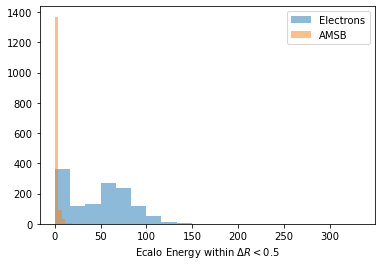

In [21]:
_ = plt.hist(ecalo_energy[np.where(true==0)],bins=20,label="Electrons",alpha=0.5)
_ = plt.hist(ecalo_energy[np.where(true==1)],bins=20,label="AMSB",alpha=0.5)
plt.xlabel(r"Ecalo Energy within $\Delta R < 0.5$")
plt.legend()

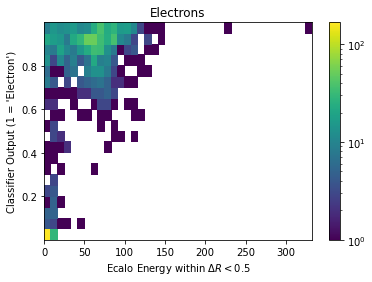

In [39]:
plt.hist2d(ecalo_energy[np.where(true==0)],preds[np.where(true==0)][:,1],bins=(40,20),norm=mpl.colors.LogNorm())
plt.title("Electrons")
plt.ylabel("Classifier Output (1 = 'electron')")
plt.xlabel(r"Ecalo Energy within $\Delta R < 0.5$")
plt.colorbar()

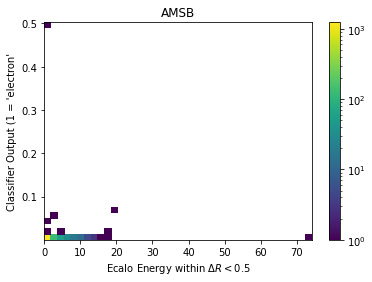

In [45]:
plt.hist2d(ecalo_energy[np.where(true==1)],preds[np.where(true==1)][:,1],bins=(40,40),norm=mpl.colors.LogNorm())
plt.title("AMSB")
plt.ylabel("Classifier Output (1 = 'electron'")
plt.xlabel(r"Ecalo Energy within $\Delta R < 0.5$")
plt.colorbar()

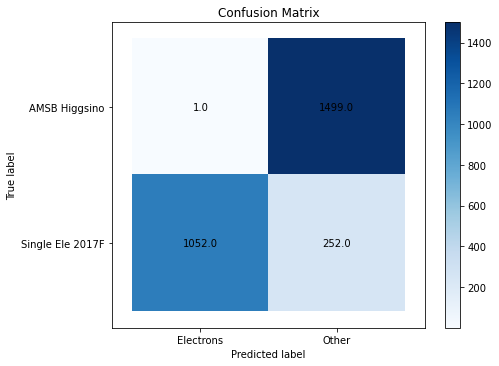

In [41]:
#convert to array of floats
cm = np.zeros([2,2])
for t,p in zip(true,preds[:,1]):
    if(t>0.5):
        if(p>0.5):
            cm[0,0]+=1
        else:
            cm[0,1]+=1
    else:
        if(p>0.5):
            cm[1,0]+=1
        else:
            cm[1,1]+=1

plt.figure(figsize=(7, 5))
target_names_x = ['Electrons','Other']
target_names_y = ['AMSB Higgsino','Single Ele 2017F']
plt.imshow(cm,cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names_x))
plt.xticks(tick_marks, target_names_x)
plt.yticks(tick_marks, target_names_y)
plt.axis('equal')
plt.tight_layout()

width, height = cm.shape
for x in range(width):
        for y in range(height):
                plt.annotate(str(cm[x][y]), xy=(y, x), 
                                        horizontalalignment='center',
                                        verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('filename.png', dpi=300)

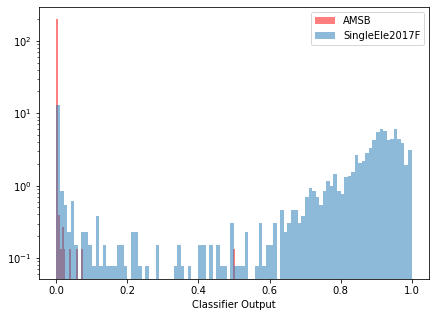

In [47]:
preds_amsb = preds[np.where(true == 1)]
preds_amsb = preds_amsb[:,1]
preds_ele = preds[np.where(true == 0)]
preds_ele = preds_ele[:,1]

plt.figure(figsize=(7, 5))
plt.yscale('log')
_ = plt.hist(preds_amsb,density=True,label="AMSB",alpha=0.5,bins=100,color="red")
_ = plt.hist(preds_ele,density=True,label="SingleEle2017F",alpha=0.5,bins=100)
plt.xlabel("Classifier Output")
plt.legend()
plt.savefig('classifier_output.png', dpi=300)

In [43]:
etas = outputs['etas']
phis = outputs['phis']

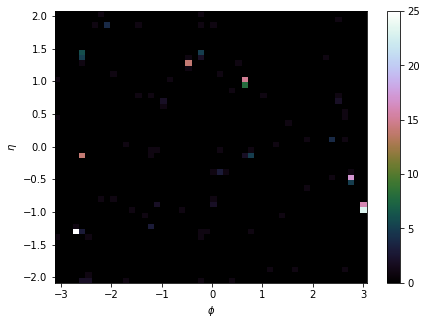

In [44]:
etas_ele, phis_ele = [], []
for e, p, t, pr in zip(etas, phis, true, preds[:,1]):
    if(t == 0 and pr < 0.5):
        etas_ele.append(e)
        phis_ele.append(p)
        
# from matplotlib import rc

# rc('font', **{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
        
plt.figure(figsize=(7, 5))
_ = plt.hist2d(phis_ele, etas_ele, bins=(50,50),cmap='cubehelix')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\eta$')
plt.colorbar()
plt.savefig(trainDir+'plots/missed_ele_dist.png', dpi=1000)